下面我们开始尝试做图形的预处理。

图片亮度调整：
https://www.programcreek.com/python/example/93845/skimage.exposure.adjust_gamma
    
http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.adjust_gamma
    
        

../data/sandbox/03755
shape of images is:  (120, 64, 64)
sandbox:  120 54 [[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]
image_data:  [[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


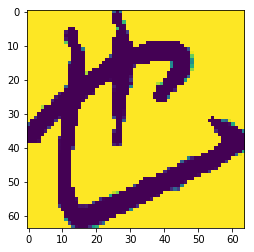

In [18]:
import os
import random
from PIL import *
from numpy import array
import numpy as np

IMAGE_SIZE = 64
CHARSET_SIZE = 3755

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.exposure import adjust_gamma

class DataIterator:
    def __init__(self, data_dir):
        # Set FLAGS.charset_size to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print(truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        image_gamma_adjust = [adjust_gamma(image, 100.023) for image in image_resized]
        self.images = [rgb2gray(item) for item in image_gamma_adjust]
        self.images = array(self.images)
        print ('shape of images is: ', self.images.shape)

    @property
    def size(self):
        return len(self.labels)
    
test_feeder = DataIterator(data_dir='../data/sandbox/')
print ('sandbox: ', test_feeder.size, test_feeder.labels[0], test_feeder.images[0])


# show image
import matplotlib.pyplot as plt
first_array=test_feeder.images[0]
image_data = first_array.reshape((IMAGE_SIZE, IMAGE_SIZE))
print ('image_data: ', image_data)


#Not sure you even have to do that if you just want to visualize it
#first_array=255*first_array
#first_array=first_array.astype("uint8")
plt.imshow(image_data)
#Actually displaying the plot if you are not in interactive mode
plt.show()


gamma值不能为负数；小于1时，感觉为虚化；大于1时，感觉为清晰。gamma越大，感觉字越黑。
gamma不能为0，为0时啥也看不到了。
下面生成3个随机数；第一个决定使用第2或第3个。第2个在0.001到1之间；第3个在1到100之间。
gamma可以是浮点数。

下面开始，使用随机gamma校正，进行训练：



In [17]:
import numpy as np

def getRndGamma():
    rnd1 = np.random.random_sample()
    rnd2 = np.random.random_sample()+0.001
    rnd3 = np.random.random_sample()*100

    if (rnd1 > 0.5):
        return rnd3
    else:
        return rnd2
    
for i in range(10):
    print ('Now gamma is: ', getRndGamma())


Now gamma is:  35.63531873626058
Now gamma is:  15.897960556356905
Now gamma is:  27.994421655052847
Now gamma is:  44.16529469038058
Now gamma is:  0.05543274605488946
Now gamma is:  89.04885696589729
Now gamma is:  59.41075711674206
Now gamma is:  96.00331776236297
Now gamma is:  0.9519012166236435
Now gamma is:  16.476647909770293


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
from numpy import array

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.exposure import adjust_gamma

IMAGE_SIZE = 64
FULL_CHARSET_SIZE = 3755
CHARSET_SIZE = 37

def getRndGamma():
    rnd1 = np.random.random_sample()
    rnd2 = np.random.random_sample()+0.001
    rnd3 = np.random.random_sample()*100

    if (rnd1 > 0.5):
        return rnd3
    else:
        return rnd2

def input(dataset):
    return dataset.images, dataset.labels

class DataSetLoader:
    def __init__(self, data_dir):
        # Set CHARSET_SIZE to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print('Now processing path: ', truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        image_gamma_adjusted = [adjust_gamma(image, getRndGamma()) for image in image_resized]
        self.images = [rgb2gray(item) for item in image_gamma_adjusted]
        
        # convert list to numpy array
        self.images = array(self.images)
        self.labels = array(self.labels)

# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[IMAGE_SIZE, IMAGE_SIZE])]

# Build 2 layer DNN classifier
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[1024, 1024, 1024, 1024, 1024],
    optimizer=tf.train.AdamOptimizer(1e-4),
    n_classes=CHARSET_SIZE,
    dropout=0.1,
    model_dir="../dfs/checkpoint/dnn7_model_c"
)
for i in range(10):
    train_data = DataSetLoader(data_dir='../data/train_/')
    print ('Train data loaded for the %d times.'%(i+1))
    # Define the training inputs
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": input(train_data)[0]},
        y=input(train_data)[1],
        num_epochs=None,
        batch_size=50,
        shuffle=True
    )

    classifier.train(input_fn=train_input_fn, steps=2000)


print ('Train done, begin to test ...')
test_data = DataSetLoader(data_dir='../data/test_/')
# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    y=input(test_data)[1],
    num_epochs=1,
    shuffle=False
)

# Evaluate accuracy
accuracy_score = classifier.evaluate(input_fn=test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../dfs/checkpoint/dnn7_model_c', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
Now processing path:  ../data/train_/00037
Train data loaded for the 1 times.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_c/model.ckpt-20000
INFO:tensorflow:Saving checkpoints for 20001 into ../dfs/checkpoint/dnn7_model_c/model.ckpt.
INFO:tensorflow:loss = 24.5863, step = 20001
INFO:tensorflow:global_step/sec: 15.1529
INFO:tensorflow:loss = 9.98742, step = 20101 (6.602 sec)
INFO:tensorflow:global_step/sec: 15.714
INFO:tensorflow:loss = 24.7689, step = 20201 (6.363 sec)
INFO:tensorflow:global_step/sec: 15.9078
INFO:tensorflow:loss = 31.6296, step = 20301 (6.287 sec)
INF

下面开始测试：


In [1]:
# from: https://www.kaggle.com/jeffcarp/example-save-and-load-a-tensorflow-model

import tensorflow as tf
import numpy as np
import os
import random
from numpy import array

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize

from tensorflow.contrib.learn.python.learn.estimators import run_config
from tensorflow.contrib.training.python.training import hparam

IMAGE_SIZE = 64
# CHARSET_SIZE = 3755
CHARSET_SIZE = 37

def input(dataset):
    return dataset.images, dataset.labels

class DataSetLoader:
    def __init__(self, data_dir):
        # Set CHARSET_SIZE to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print('Now processing path: ', truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        self.images = [rgb2gray(item) for item in image_resized]
        
        # convert list to numpy array
        self.images = array(self.images)
        self.labels = array(self.labels)

# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[IMAGE_SIZE, IMAGE_SIZE])]

def make_estimator(model_dir):
    config = run_config.RunConfig(model_dir=model_dir)

    return tf.estimator.DNNClassifier (
        config=config,
        feature_columns=feature_columns,
    hidden_units=[1024, 1024, 1024, 1024, 1024],
    optimizer=tf.train.AdamOptimizer(1e-4),
    n_classes=CHARSET_SIZE,
    dropout=0.1)
    

MODEL_DIR = "../dfs/checkpoint/dnn7_model_c"
model_from_checkpoint = make_estimator(MODEL_DIR)

test_data = DataSetLoader(data_dir='../data/test_/')
# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    y=input(test_data)[1],
    num_epochs=1,
    shuffle=False
)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    num_epochs=1,
    shuffle=False)

# Evaluate accuracy
accuracy_score = model_from_checkpoint.evaluate(input_fn=test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f64305999b0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../dfs/checkpoint/dnn7_model_b'}
Now processing path:  ../data/test_/00037
INFO:tensorflow:Starting evaluation at 2018-04-21-08:54:21
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_b/model.ckpt-24000
INFO:tensorflow:Finished evaluation at 2018-04-21-08:54:24
INFO:tensorflow:Saving dict for global step 24000: accuracy = 0.762443, average_loss = 0.915754

上面第一轮，
INFO:tensorflow:Starting evaluation at 2018-04-21-11:02:37
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_c/model.ckpt-20000
INFO:tensorflow:Finished evaluation at 2018-04-21-11:02:38
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.744344, average_loss = 1.15895, global_step = 20000, loss = 142.294

Test Accuracy: 74.434388%



再来一轮20000步，看看有否长进。

